In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
!wget -O bronze.zip http://grail.cs.washington.edu/projects/photomontage/data/bronze.zip && unzip -o bronze.zip

bronze.zip          100%[===================>] 320.46K  1.20KB/s    in 6.6s    

2022-04-18 08:30:23 (48.9 KB/s) - ‘bronze.zip’ saved [328148/328148]

Archive:  bronze.zip
  inflating: IMG_3083.JPG            
  inflating: IMG_3084.JPG            
  inflating: IMG_3085.JPG            
  inflating: IMG_3086.JPG            
  inflating: IMG_3087.JPG            
  inflating: IMG_3088.JPG            
  inflating: IMG_3089.JPG            
  inflating: IMG_3090.JPG            
  inflating: IMG_3091.JPG            
  inflating: IMG_3092.JPG            
  inflating: IMG_3093.JPG            
  inflating: IMG_3094.JPG            
  inflating: IMG_3095.JPG            
  inflating: IMG_3096.JPG            
  inflating: IMG_3097.JPG            
  inflating: IMG_3098.JPG            
  inflating: result.png              


In [3]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

def h_color(a, interpolation=None):
  s = [a.shape[0] * 2, a.shape[1] * 2]
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap="gray", interpolation=interpolation)

css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td { 
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""

def h(s):
   return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

def h_color_3d(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.show()

In [143]:
# PARAMETRY

LOWER_THE_MEAN_MASK = 15
BACKGROUND_BRIGHTNESS_THRESHOLD = 13
MIN_OBJECT_SIZE = 100
THE_BRIGHTEST_POINTS_THRESHOLD = 1.0
TEST_BRIGHTNESS_THRESHOLD = 0.2
AREA_BRIGHTNESS_THRESHOLD = 150

In [193]:
files = [
    '/content/IMG_3083.JPG',
    '/content/IMG_3084.JPG',
    '/content/IMG_3085.JPG',
    '/content/IMG_3086.JPG',
    '/content/IMG_3087.JPG',
    '/content/IMG_3088.JPG',
    '/content/IMG_3089.JPG',
    '/content/IMG_3090.JPG',
    '/content/IMG_3091.JPG',
    '/content/IMG_3092.JPG',
    '/content/IMG_3093.JPG',
    '/content/IMG_3094.JPG',
    '/content/IMG_3095.JPG',
    '/content/IMG_3096.JPG',
    '/content/IMG_3097.JPG',
]

figures = [cv2.imread(f, 1) for f in files]

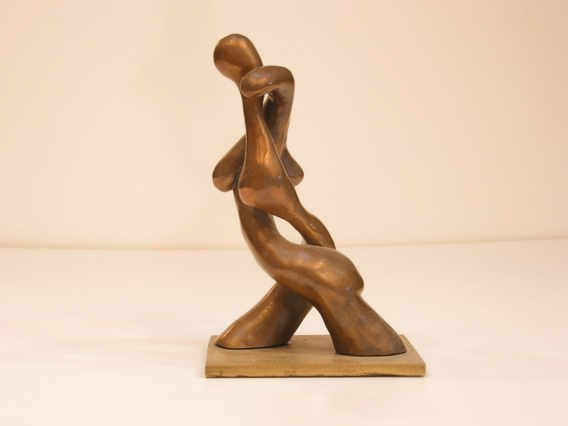

In [194]:
def increase_the_brightness(images, threshold):
  images = [i*threshold for i in images]
  return images

def get_the_brightest_image(images):
  flatten_images = [i.flatten() for i in images]
  images_avg = [np.mean(i) for i in flatten_images]
  return images[np.argmax(images_avg)]

def get_average_image(images):
  flatten_images = [i.flatten() for i in images]
  avg_img = np.zeros(len(flatten_images[0]))
  for i in flatten_images:
    avg_img = np.add(avg_img, i)
  avg_img /= len(images)
  return np.float32(np.reshape(np.around(avg_img), images[0].shape))

avg_img = get_average_image(figures)
img_grayscale = cv2.cvtColor(avg_img, cv2.COLOR_BGR2GRAY)

imshow(avg_img)

In [202]:
def get_mean_mask(image, threshold):
  tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return tmp>np.mean(tmp)-threshold

mask = get_mean_mask(avg_img, LOWER_THE_MEAN_MASK)

def get_object_without_base(grayscale_image):
  bightness = np.mean(grayscale_image)
  tmp = np.array([[255 if j > bightness-100 and j < bightness-20 else 0 for j in i] for i in img_grayscale])
  tmp = np.array([[0 if idx < 340 else col for _, col in enumerate(row)] for idx, row in enumerate(tmp)])
  _, _, stats, _ = cv2.connectedComponentsWithStats(tmp.astype('uint8'), 4, cv2.CV_32S)

  for obj in stats[1:]:
    if obj[4] < 5000:
      for i in range(obj[1], obj[1]+obj[3]-1):
        for j in range(obj[0], obj[0]+obj[2]-1):
          tmp[i][j] = 0

  struct = np.ones([3, 3], np.uint8)
  img_space_close = cv2.morphologyEx(tmp.astype('uint8'), cv2.MORPH_CLOSE, struct)
  return tmp

def combine_masks(mask1, mask2):
  return np.array([[True if mask1[i][j] == True or mask2[i][j] == 255 else False for j, _ in enumerate(row)] for i, row in enumerate(mask1)])

mask = combine_masks(mask, get_object_without_base(img_grayscale))



In [203]:
from copy import deepcopy

# threshold 0-14
def modify_background_brightness(mask, img, images, threshold):
  image = deepcopy(img)
  gray_images = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in images]
  for row_idx, i in enumerate(mask):
    for col_idx, j in enumerate(i):
      if j == True:
        image[row_idx][col_idx] = images[np.argsort(np.array([k[row_idx][col_idx] for k in gray_images]))[threshold]][row_idx][col_idx]
  return image

avg_img = modify_background_brightness(mask, avg_img, figures, BACKGROUND_BRIGHTNESS_THRESHOLD)

ENTRY DATA PREPARED
0  IMAGE ANALISED
1  IMAGE ANALISED
2  IMAGE ANALISED
3  IMAGE ANALISED
4  IMAGE ANALISED
5  IMAGE ANALISED
6  IMAGE ANALISED
7  IMAGE ANALISED
8  IMAGE ANALISED
9  IMAGE ANALISED
10  IMAGE ANALISED
11  IMAGE ANALISED
12  IMAGE ANALISED
13  IMAGE ANALISED
14  IMAGE ANALISED


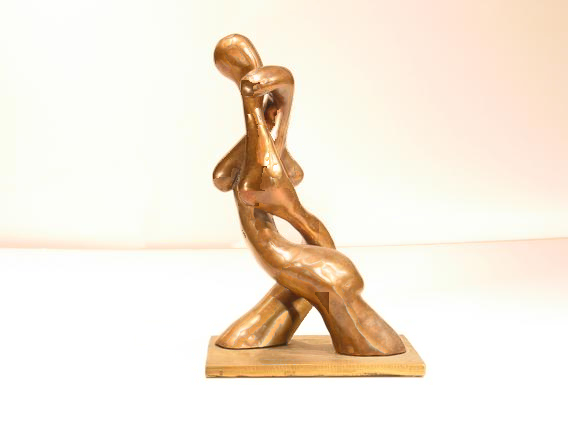

In [204]:
o_img = deepcopy(avg_img)
a_img = deepcopy(avg_img)

def get_the_brightest_points(image, mask, threshold):
  image = cv2.bilateralFilter(image, 9,75,75)
  brightness = np.mean(image[mask == False])
  return np.array([[True if not mask[row_idx][col_idx] and np.mean(image[row_idx][col_idx]) > brightness*threshold else False for col_idx, k in enumerate(j)] 
                   for row_idx, j in enumerate(image)])

def prepare_entry_data(image, mask):
  struct = np.ones([2, 2], np.uint8)
  matrix = np.array([[255 if j else 0 for j in i] for i in get_the_brightest_points(image, mask, THE_BRIGHTEST_POINTS_THRESHOLD)]) 
  # img_space_close = cv2.morphologyEx(matrix.astype('uint8'), cv2.MORPH_CLOSE, struct)
  return cv2.erode(matrix.astype('uint8'), struct)

# Przygotowujemy zdjęcia w formie czarnobiałych map przedstawiających najjaśniejsze punkty na zdjęciu
images = np.array([prepare_entry_data(i, mask) for i in figures])
print("ENTRY DATA PREPARED")


for img_idx, img_erode in enumerate(images):
  # Znajdujemy współrzędne poszczególnych jasnych punktów
  _, _, stats, _ = cv2.connectedComponentsWithStats(img_erode, 4, cv2.CV_32S)
  stats = stats[1:]
  # Robimy maskę obiektów tylko o określonym rozmiarze
  objects_size_mask = stats[:, 4] > MIN_OBJECT_SIZE
  objects_comparison_matrix = np.empty((0, len(figures)))

  # Dla każdego białego obiektu na mapie sprawdzamy jego jasność i porównujemy ja z jasnością tego samego obszaru na innych zdjęciach
  for k in stats[:][objects_size_mask]:
    obj = np.array([[True if img_erode[i1][j1] == 255 else False for j1 in range(k[0], k[0]+k[2]-1)] for i1 in range(k[1], k[1]+k[3]-1)])
    avg_brightness = sum(sum(1 if j2 == True else 0 for j2 in i2) for i2 in obj) / len(obj.flatten()) 
    objects_comparison_array = np.array([])
    
    for img_erode2 in images:
      obj2 = np.array([[True if img_erode2[i1][j1] == 255 else False for j1 in range(k[0], k[0]+k[2]-1)] for i1 in range(k[1], k[1]+k[3]-1)])
      avg_brightness2 = sum(sum(1 if j2 == True else 0 for j2 in i2) for i2 in obj2) / len(obj2.flatten())
      objects_comparison_array = np.append(objects_comparison_array, avg_brightness2-avg_brightness)
    
    objects_comparison_matrix = np.vstack([objects_comparison_matrix, objects_comparison_array])

  # Szukamy najjaśniejszego fragmentu zdjęcia w danym obszarze
  for point_idx, k in enumerate(objects_comparison_matrix):
    points = stats[:][objects_size_mask][point_idx]
    avg_brightness = 0
    max_brightness_idx = img_idx
    objects_comparison_array = k

    while True:
      if np.max(objects_comparison_array) > 0:
        max_brightness_idx = np.argmax(objects_comparison_array)
        obj = np.array([[True if images[max_brightness_idx][i1][j1] == 255 else False for j1 in range(points[0], points[0]+points[2]-1)] for i1 in range(points[1], points[1]+points[3]-1)])
        avg_brightness = sum(sum(1 if j2 == True else 0 for j2 in i2) for i2 in obj) / len(obj.flatten()) 
      else:
        break
      
      objects_comparison_array = np.array([])

      for img_erode2 in images:
        obj2 = np.array([[True if img_erode2[i1][j1] == 255 else False for j1 in range(points[0], points[0]+points[2]-1)] for i1 in range(points[1], points[1]+points[3]-1)])
        avg_brightness2 = sum(sum(1 if j2 == True else 0 for j2 in i2) for i2 in obj2) / len(obj2.flatten())
        objects_comparison_array = np.append(objects_comparison_array, avg_brightness2-avg_brightness)
    
    x = (points[0]+points[2]-1 - points[0]) * (points[1]+points[3]-1 - points[1])
    # Sprawdzamy jasność wyznaczonego, najjaśniejszego fragmentu
    test_brightness = sum(sum(1 if images[max_brightness_idx][i1][j1] == 255 else 0 for j1 in range(points[0], points[0]+points[2]-1)) for i1 in range(points[1], points[1]+points[3]-1))/x
    # Sprawdzamy jasność obszaru na modyfikowanym zdjęciu, aby sprawdzić czy nie została ona już zmieniona
    area_brightness = sum(sum(np.mean(a_img[i1][j1]) for j1 in range(points[0], points[0]+points[2]-1)) for i1 in range(points[1], points[1]+points[3]-1))/x 

    # Wprowadzamy zmiany
    if test_brightness > TEST_BRIGHTNESS_THRESHOLD and area_brightness < AREA_BRIGHTNESS_THRESHOLD:
      for i1 in range(points[1], points[1]+points[3]-1):
          for j1 in range(points[0], points[0]+points[2]-1):
            if images[max_brightness_idx][i1][j1] == 255:
              
              a_img[i1][j1] = figures[max_brightness_idx][i1][j1]
    
  print(img_idx, " IMAGE ANALISED")

imshow(a_img)

Poniżej jakieś testy

In [ ]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask,(s[0]//2, s[1]//2), s[0]//div, 1, -1)

def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum

def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

In [ ]:
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

# intensity

f_lap_shift, f_lap_mag = fft(laplacian, (426, 568))
fshift, spectrum = fft(img_grayscale)
img_i = ifft(fshift * f_lap_shift)

img_i = np.array([[0 if j > 4 else 255 for j in i] for i in img_i])

#imshow(img_i)

struct = np.ones([1, 1], np.uint8)

#imshow(cv2.erode(img_i.astype('uint8'), struct))

img_space_close = cv2.morphologyEx(img_i.astype('uint8'), cv2.MORPH_OPEN, struct)
img_space_open = cv2.morphologyEx(img_space_close, cv2.MORPH_OPEN, struct)
img_space_close2 = cv2.morphologyEx(img_space_open, cv2.MORPH_CLOSE, struct)

img_space_close = cv2.morphologyEx(img_space_close.astype('uint8'), cv2.MORPH_CLOSE, struct)

x = cv2.bilateralFilter(img_space_close, 9,75,75)
x_mean = np.mean(x)
x = np.array([[255 if j > x_mean else 0 for j in i] for i in x])
x = np.array([[x[row_idx][col_idx] if j == False else 255 for col_idx, j in enumerate(i)] for row_idx, i in enumerate(mask)])

imshow(x)

for i in x:
  for j in range(len(i)):
    if j!=len(i)-1 and i[j] != i[j+1]:
      i[j] = 255

imshow(x)